# From cosmology to linear power parameters
We would like to see if we can compress the linear power spectrum information in a handful of parameters.

In [1]:
%matplotlib inline
import numpy as np
import os
## Set default plot size, as normally its a bit too small
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 120
mpl.rcParams['figure.dpi'] = 120
import camb
from camb import model, initialpower
import fit_pk
import read_genic

### Specify cosmological models

In [2]:
# read cosmology from GenIC file
cosmo_genic = 'param_keir.genic'
#cosmo_genic = 'param_chris.genic'
cosmo_dict = read_genic.camb_from_genic(cosmo_genic)
#print(cosmo_dict)
pars = fit_pk.get_cosmology(cosmo_dict)

In [3]:
# setup fiducial cosmology
pars_fid = fit_pk.get_cosmology(mnu=0.3)

### Compute ratio of power at $z_\star=3$ and fit a polynomial to log ratio

In [4]:
z_star=3.0
kmin_kms=0.001
kmax_kms=0.05
linP_ratio_kms = fit_pk.fit_linP_ratio_kms(pars,pars_fid,z_star,kmin_kms,kmax_kms,deg=2)

### Compute logarithmic growth rate for both cosmologies

In [5]:
f_star = fit_pk.get_f_star(pars,z_star)
f_star_fid = fit_pk.get_f_star(pars_fid,z_star)
print('f_star =',f_star)
print('f_star_fid =',f_star_fid)

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
f_star = 0.973281336575
f_star_fid = 0.968990127064


### Compute derivative of Hubble parameter, with respect to EdS

In [6]:
g_star = fit_pk.get_g_star(pars,z_star)
g_star_fid = fit_pk.get_g_star(pars_fid,z_star)
print('g_star =',g_star)
print('g_star_fid =',g_star_fid)

g_star = 0.9533398806278037
g_star_fid = 0.9687130850033866


## All in one function

In [7]:
linP_params=fit_pk.parameterize_cosmology(pars,pars_fid,z_star=z_star)

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


### Reconstruct the linear power using the shape parameters and the logarithmic growth rate

In [8]:
# compute first linear power spectra, in velocity units
# output redshifts
zs=[2,3,4,5]
Nz=len(zs)
# these are the power spectra that we would like to recover
k_kms, zs_out, P_kms = fit_pk.get_linP_kms(pars,zs)

Note: redshifts have been re-sorted (earliest first)


Note: redshifts have been re-sorted (earliest first)


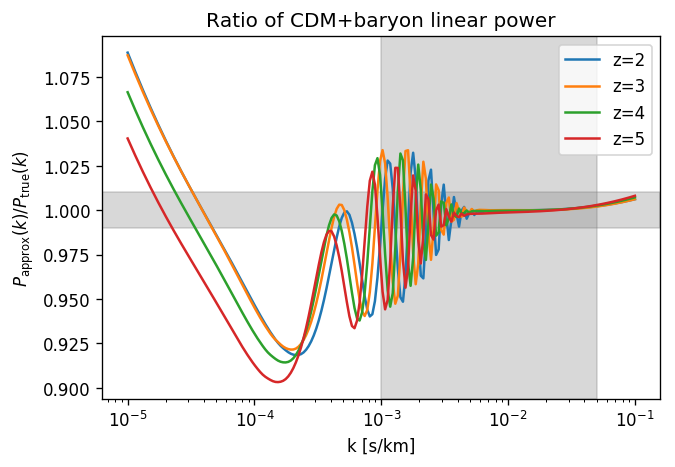

In [9]:
plt.figure()
fix_evol=True
fix_grow=True
k=np.logspace(-5,-1,200)
linP_kms=fit_pk.reconstruct_linP_kms(zs,k,pars_fid,linP_params,z_star)
for iz in range(Nz): 
    z=zs[iz]
    P_true=np.interp(k,k_kms[iz],P_kms[iz])
    P_rec=linP_kms[iz]
    plt.semilogx(k,P_rec/P_true,label='z='+str(z))
plt.title(r"Ratio of CDM+baryon linear power")
plt.xlabel("k [s/km]")
plt.ylabel(r"$P_{\rm approx}(k) / P_{\rm true}(k)$")
plt.legend()
plt.axhspan(0.99,1.01,alpha=0.3, color='gray')
plt.axvspan(0.001,0.05,alpha=0.3, color='gray')